What is Resume Screening?

Hiring the right talent is a challenge for all businesses. This challenge is magnified by the high volume of applicants if the business is labour-intensive, growing, and facing high attrition rates.

An example of such a business is that IT departments are short of growing markets. In a typical service organization, professionals with a variety of technical skills and business domain expertise are hired and assigned to projects to resolve customer issues. This task of selecting the best talent among many others is known as Resume Screening.

Typically, large companies do not have enough time to open each CV, so they use machine learning algorithms for the Resume Screening task.

In [1]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
# Load dataset

resumeDataSet = pd.read_csv('UpdatedResumeDataSet.csv' ,encoding='utf-8')

resumeDataSet.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [3]:
# let’s have a quick look at the unique categories

print(resumeDataSet['Category'].unique())
print (resumeDataSet['Category'].value_counts())

['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
Operations Manager           40
Mechanical Engineer          40
Data Science                 40
ETL Developer                40
Sales                        40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
DotNet Developer           

<AxesSubplot:xlabel='count', ylabel='Category'>

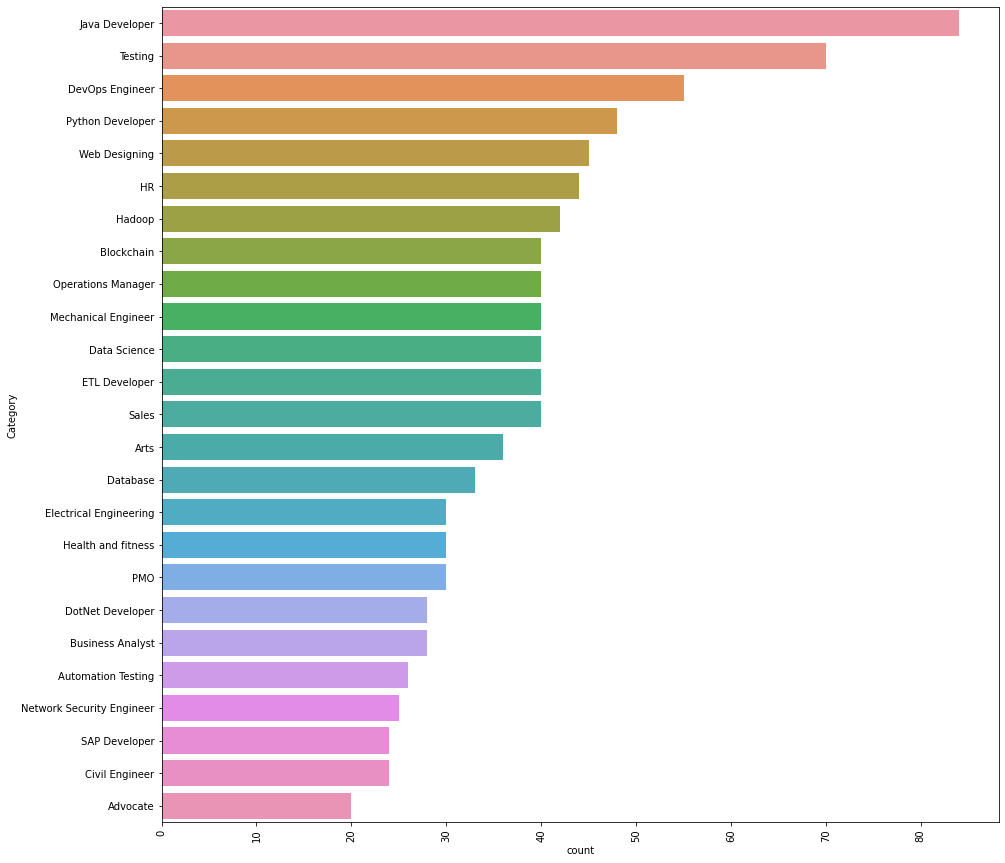

In [4]:
# Visualize the number of categories in the dataset

import seaborn as sns
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=resumeDataSet, order = resumeDataSet['Category'].value_counts().index)

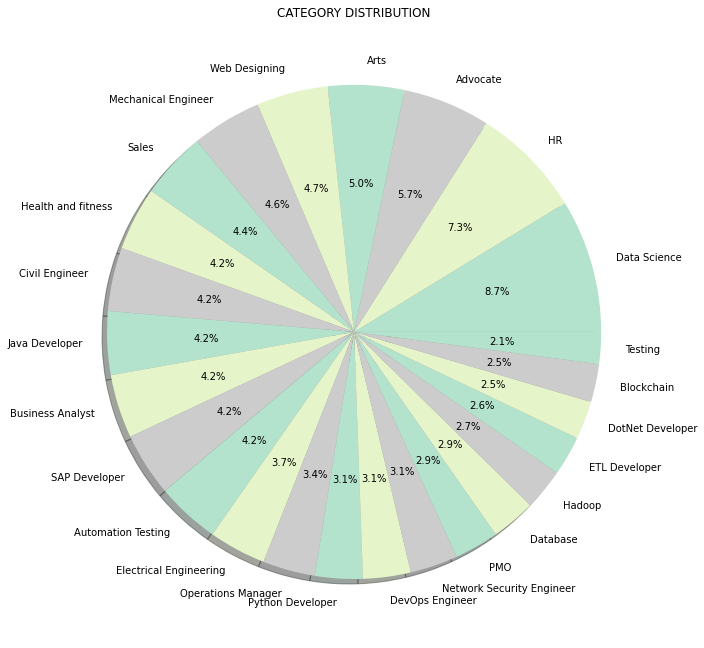

In [5]:
# I try to avoid piecharts, this is the one and only time i try to use it :)

from matplotlib.gridspec import GridSpec
targetCounts = resumeDataSet['Category'].value_counts()
targetLabels  = resumeDataSet['Category'].unique()

# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)

cmap = plt.get_cmap('Pastel2')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

In [6]:
# Lets clean up: remove the URLs, hashtags, mentions, special letters, and punctuations

import re
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

# Add new column and store the clean resume version

resumeDataSet['cleaned_resume'] = ''
resumeDataSet['cleaned_resume'] = resumeDataSet.Resume.apply(lambda x: cleanResume(x))
resumeDataSet.tail()

,Category,Resume,cleaned_resume
957,Testing,Computer Skills: â¢ Proficient in MS office (...,Computer Skills Proficient in MS office Word B...
958,Testing,â Willingness to accept the challenges. â ...,Willingness to a ept the challenges Positive ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",PERSONAL SKILLS Quick learner Eagerness to lea...
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power Po...
961,Testing,Skill Set OS Windows XP/7/8/8.1/10 Database MY...,Skill Set OS Windows XP 7 8 8 1 10 Database MY...


[nltk_data] Downloading package punkt to C:\Users\Jovan
[nltk_data]     Trajceski\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('Details', 484), ('Exprience', 446), ('months', 376), ('company', 330), ('description', 310), ('1', 290), ('year', 232), ('January', 216), ('Less', 204), ('Data', 200), ('data', 192), ('Skill', 166), ('Maharashtra', 166), ('6', 164), ('Python', 156), ('Science', 154), ('I', 146), ('Education', 142), ('College', 140), ('The', 126), ('project', 126), ('like', 126), ('Project', 124), ('Learning', 116), ('India', 114), ('Machine', 112), ('University', 112), ('Web', 106), ('using', 104), ('monthsCompany', 102), ('B', 98), ('C', 98), ('SQL', 96), ('time', 92), ('learning', 90), ('Mumbai', 90), ('Pune', 90), ('Arts', 90), ('A', 84), ('application', 84), ('Engineering', 78), ('24', 76), ('various', 76), ('Software', 76), ('Responsibilities', 76), ('Nagpur', 76), ('development', 74), ('Management', 74), ('projects', 74), ('Technologies', 72)]


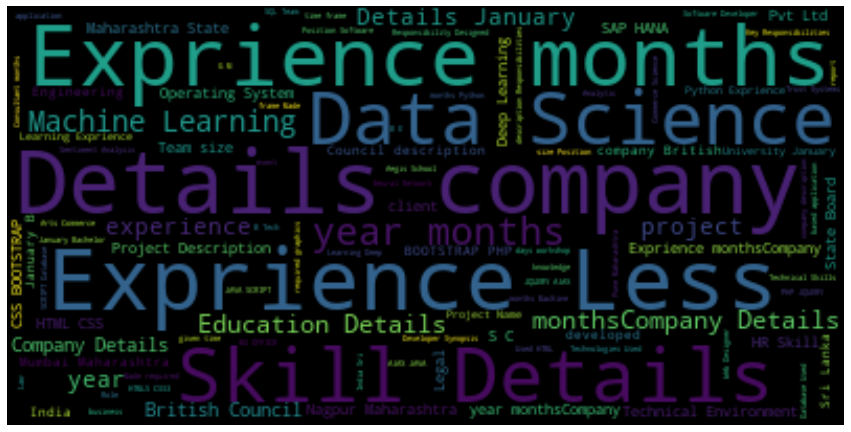

In [7]:
# Lets create a wordcloud

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = resumeDataSet['Resume'].values
cleanedSentences = ""
for i in range(0,160):
    cleanedText = cleanResume(Sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
# Convert these words into categorical values

from sklearn.preprocessing import LabelEncoder

var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    resumeDataSet[i] = le.fit_transform(resumeDataSet[i])

In [9]:
# Training Machine Learning Model for Resume Screening (Target = Category)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

requiredText = resumeDataSet['cleaned_resume'].values
requiredTarget = resumeDataSet['Category'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

print ("Feature completed .....")

X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=0, test_size=0.2)
print(X_train.shape)
print(X_test.shape)


Feature completed .....
(769, 1500)
(193, 1500)


In [10]:
# Train model and print out report

clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction)))

Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set: 0.99

 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.